# 1. Importing Required Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import csv
import warnings
import tempfile

import torch
import pytorch_lightning as pl
import torch.nn as nn
import torch.nn.functional as F
import optuna
import torch.optim as optim

from sklearn.datasets import fetch_california_housing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter



In [2]:
# Suppress Optuna warnings for cleaner output
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
current_dir = os.getcwd()
print(current_dir)

c:\Aravind's File\Projects\pytorch_regression


In [4]:
# --- Configuration ---
RANDOM_SEED = 42
BATCH_SIZE = 128
NUM_TRIALS_OPTUNA = 10
LOG_DIR = os.path.join(current_dir, "runs/california_housing_regression")
CSV_LOG_FILE = os.path.join(current_dir, "runs/california_housing_regression", "training_metrics.csv")
final_CSV_LOG_FILE = os.path.join(current_dir, "runs/california_housing_regression", "fial_refit_metrics.csv")

In [5]:
# Create the folder if it doesn't exist
os.makedirs("runs/california_housing_regression", exist_ok=True)

In [6]:
# Set device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

Using device: cpu


In [7]:
# Set random seed for reproducibility
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if DEVICE == "cuda":
    torch.cuda.manual_seed_all(RANDOM_SEED)

# 2. Load the California housing dataset

In [8]:
data = fetch_california_housing()
data_df = fetch_california_housing(as_frame=True)
data_df = data_df.frame
target_column = 'MedHouseVal'

In [9]:
data_df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [10]:
# Description of the dataset
data_description = data.DESCR
for line in data_description.split('\n'):
    print(line)
# The dataset contains the following features:

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [11]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


# 3. EDA

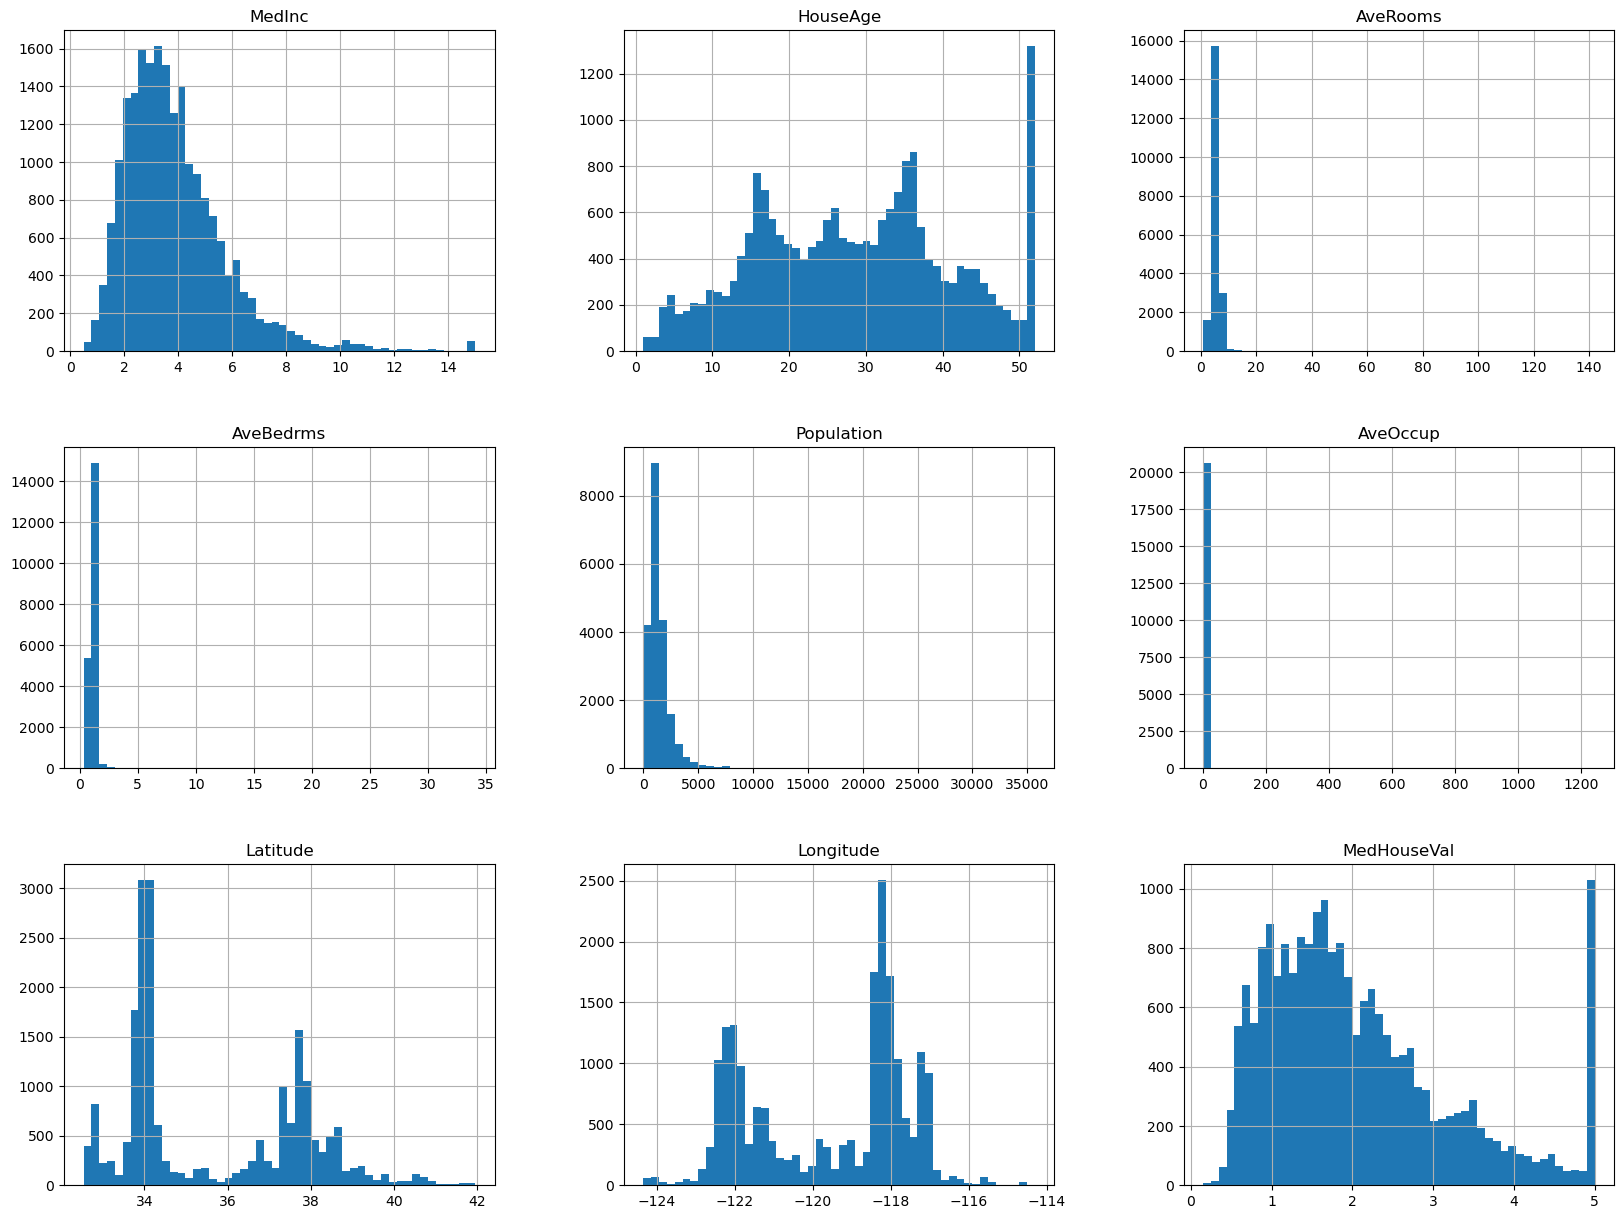

In [12]:
# Plotting the numerical features

# data_df = pd.DataFrame(data , columns=data.feature_names)
data_df.hist(bins=50, figsize=(20, 15))
plt.show()


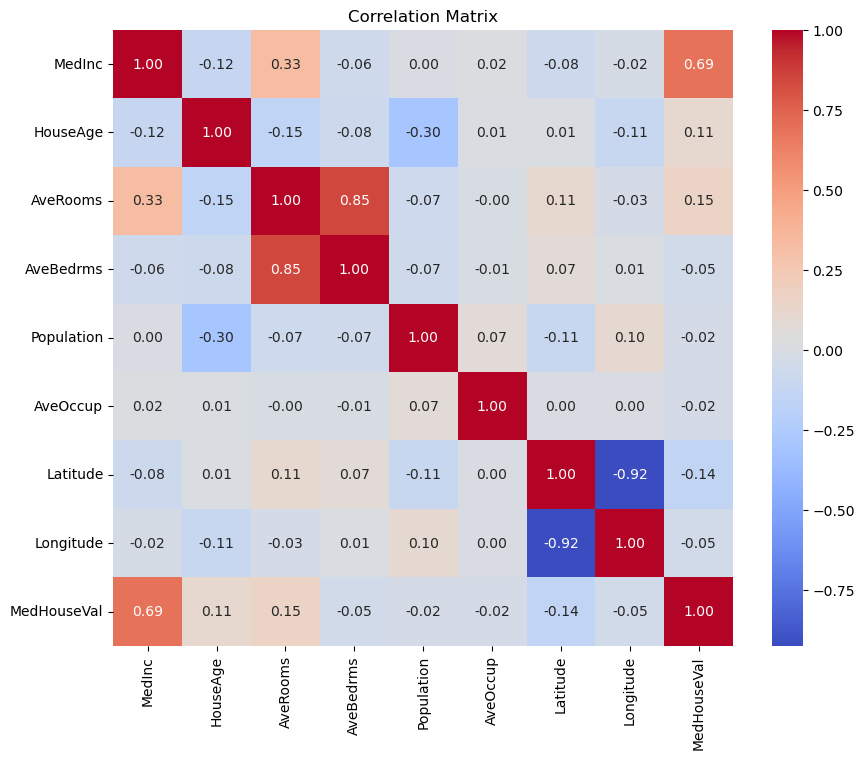

In [13]:
# # Correlation matrix

plt.figure(figsize=(10, 8))
sns.heatmap(data_df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


# 4. PCA to reduce multicollinearity

In [14]:
#pca for latitude and longitude

pca = PCA(n_components=1)
X_pca = pca.fit_transform(data_df[['Latitude', 'Longitude']])  # Assuming latitude and longitude are the first two features


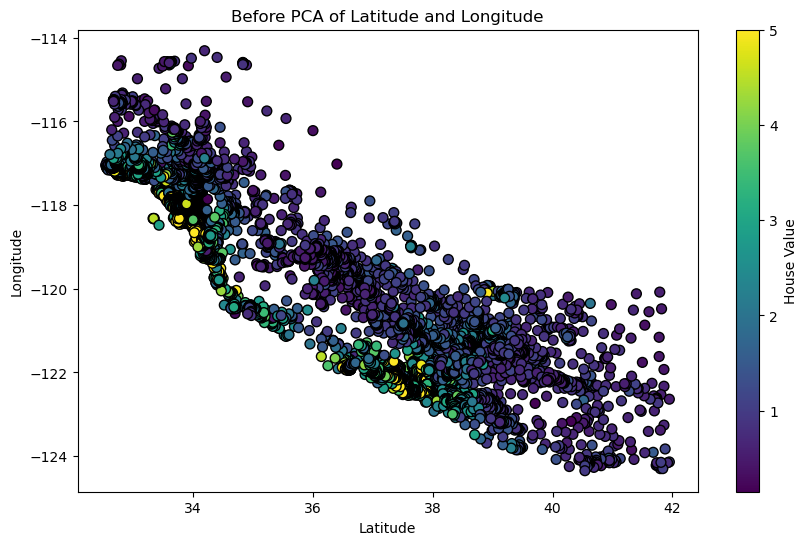

In [15]:
plt.figure(figsize=(10, 6))
plt.scatter(data_df['Latitude'], data_df['Longitude'], c=data_df['MedHouseVal'], cmap='viridis', edgecolor='k', s=50)
plt.colorbar(label='House Value')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Before PCA of Latitude and Longitude')
plt.show()

In [16]:
X_pca

array([[3.45863773],
       [3.43719276],
       [3.44352628],
       ...,
       [3.90282427],
       [3.97104826],
       [3.87260137]])

In [17]:
# replacing the original latitude and longitude with PCA components
data_df['Lat_and_Long'] = X_pca
# data_df['Longitude'] = X_pca[:, 1]
data_df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,Lat_and_Long
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526,3.458638
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585,3.437193
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521,3.443526
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413,3.450349
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422,3.450349
...,...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781,3.850689
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771,3.939870
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923,3.902824
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847,3.971048


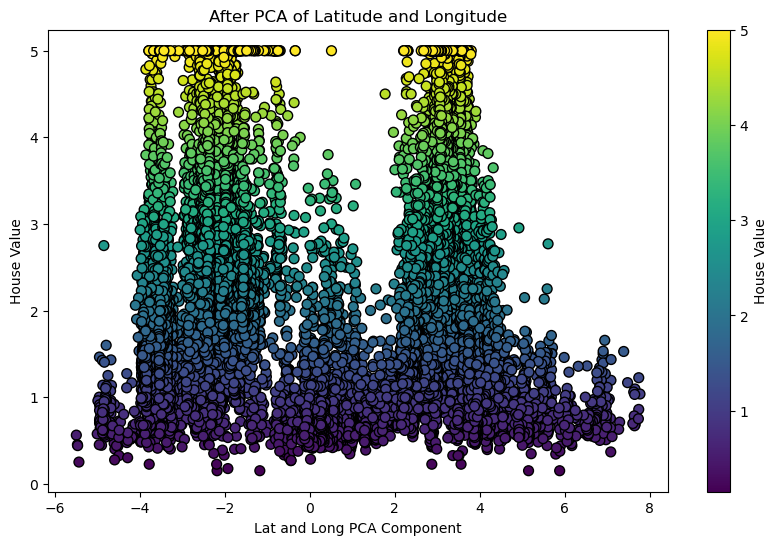

In [18]:
#Plot after PCA
plt.figure(figsize=(10, 6))
plt.scatter(data_df['Lat_and_Long'], data_df['MedHouseVal'], c=data_df['MedHouseVal'], cmap='viridis', edgecolor='k', s=50)
plt.colorbar(label='House Value')
plt.xlabel('Lat and Long PCA Component')
plt.ylabel('House Value')
plt.title('After PCA of Latitude and Longitude')
plt.show()

In [19]:
# After PCA, we can drop the original latitude and longitude columns
data_df = data_df.drop(columns=['Latitude', 'Longitude'])


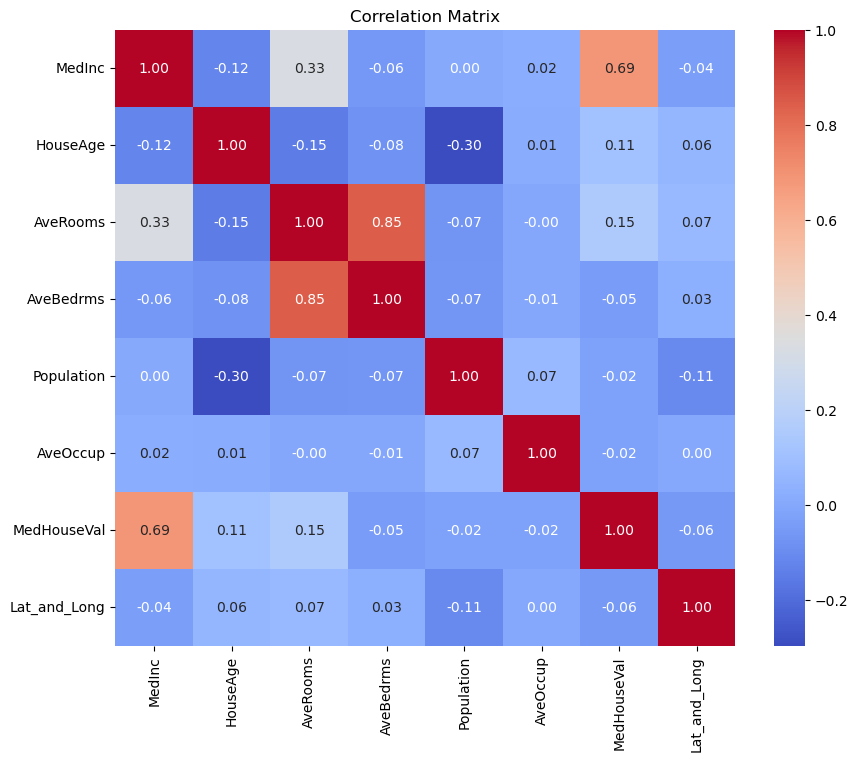

In [20]:
plt.figure(figsize=(10, 8))
sns.heatmap(data_df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# 5. Combining All preprocessing and Data loader into one function

In [21]:
def load_and_preprocess_data():
    data_df = fetch_california_housing(as_frame=True)
    data_df = data_df.frame
    target_column = 'MedHouseVal'

    #pca for latitude and longitude
    pca = PCA(n_components=1)
    X_pca = pca.fit_transform(data_df[['Latitude', 'Longitude']])  # Assuming latitude and longitude are the first two features
    data_df['Lat_and_Long'] = X_pca
    data_df = data_df.drop(columns=['Latitude', 'Longitude'])

    #normalizing the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data_df.drop(target_column, axis=1))
    # Converting the scaled data back to a DataFrame
    data_scaled_df = pd.DataFrame(X_scaled, columns=data_df.drop(target_column, axis=1).columns)
    data_scaled_df[target_column] = data_df[target_column]

    # splitting data into features and target variables
    X = data_df.drop(target_column, axis=1).values
    y = data_df[target_column].values.reshape(-1, 1) # Reshape for PyTorch

    # Convert to PyTorch Tensors
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)

    # Create a TensorDataset
    dataset = TensorDataset(X_tensor, y_tensor)

    # Define split sizes
    total_size = len(dataset)
    train_size = int(0.8 * total_size)
    val_size = int(0.1 * total_size)
    test_size = total_size - train_size - val_size

    # Split the dataset
    train_dataset, val_dataset, test_dataset = random_split(
        dataset, [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(RANDOM_SEED)  # for reproducibility
    )

    # Create DataLoaders (optional)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Print sizes
    print("Train size:", len(train_dataset))
    print("Validation size:", len(val_dataset))
    print("Test size:", len(test_dataset))

    input_dim = X_tensor.shape[1]

    return train_loader, val_loader, test_loader, input_dim

# 6. Model definition

In [22]:
class RegressionModel(nn.Module):
    def __init__(self, input_dim, hidden_layers, dropout=0.2, lr=0.001):
        super(RegressionModel, self).__init__()
        layers = []
        current_dim = input_dim  # Number of features in the input

        # Build hidden layers based on hidden_layers string (e.g., "128-64-32")
        hidden_units = [int(u) for u in hidden_layers.split('-')]

        for units in hidden_units:
            layers.append(nn.Linear(current_dim, units))
            layers.append(nn.ReLU())
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            current_dim = units

        #output layer for regression (single neuron)
        layers.append(nn.Linear(current_dim, 1))

        self.network = nn.Sequential(*layers)



    def forward(self, x):
        return self.network(x)

    def train_model(model, train_loader, val_loader, optimizer, 
                criterion, epochs, writer, csv_logger, trial = None):
        model.to(DEVICE)
        best_val_loss = float('inf')

        for epoch in range(epochs):
            model.train()
            train_loss = 0.0
            for batch_idx, (data,target) in enumerate(train_loader):
                data, target = data.to(DEVICE), target.to(DEVICE)
                optimizer.zero_grad() # Zero gradients [3, 4]
                outputs = model(data) # Forward pass [4]
                loss = criterion(outputs, target) # Calculate loss [4]
                loss.backward() # Backpropagation [3, 4]
                optimizer.step() # Update weights [3, 4]
                train_loss += loss.item() * data.size(0)

            train_loss /= len(train_loader.dataset)

            # Validation phase
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for data, target in val_loader:
                    data, target = data.to(DEVICE), target.to(DEVICE)
                    outputs = model(data)
                    loss = criterion(outputs, target)
                    val_loss += loss.item() * data.size(0)

            val_loss /= len(val_loader.dataset)

            # Log metrics [30]
            writer.add_scalar("Loss/Train", train_loss, epoch)
            writer.add_scalar("Loss/Validation", val_loss, epoch)

            # Log to CSV [28]
            csv_logger.writerow([epoch, train_loss, val_loss])

            # Print progress
            if (epoch + 1) % 10 == 0 or epoch == 0:
                print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

            # Optuna pruning (if applicable)
            if trial:
                trial.report(val_loss, epoch)
                if trial.should_prune():
                    raise optuna.exceptions.TrialPruned()
                
            # Early stopping (simple example for demonstration)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                # Save best model state if needed, not implemented here for brevity
                # torch.save(model.state_dict(), "best_model.pth")

        return val_loss
    
    # --- 4. Hyperparameter Tuning with Optuna ---
    def objective(trial):
        """Optuna objective function for hyperparameter optimization."""
        # Define hyperparameter search space [21]
        learning_rate = trial.suggest_float("lr", 0.0005, 0.001, log=True) # [2, 21]
        hidden_layers_str = trial.suggest_categorical("hidden_layers", ["21-10-5","256-128-64-32", "512-256-128", "512-256-128-64"]) # [2, 19]
        dropout_rate = trial.suggest_float("dropout", 0.0, 0.1) # [2, 16]
        epochs = 100#trial.suggest_int("epochs", 50, 500, step=50) # Limited for faster tuning example

        # Re-load data for each trial to ensure fresh split (or use fixed split outside objective)
        train_loader, val_loader, _, input_dim = load_and_preprocess_data()
        # print(input_dim)
        model = RegressionModel(input_dim, hidden_layers_str, dropout_rate).to(DEVICE)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate) # [5, 9]
        criterion = nn.MSELoss() # [2]

        # Initialize TensorBoard writer and CSV logger for this trial
        writer = SummaryWriter(log_dir=os.path.join(LOG_DIR, f"optuna_trial_{trial.number}"))
        csv_file = open(os.path.join(writer.log_dir, "metrics.csv"), 'w', newline='')

        csv_logger = csv.writer(csv_file)
        # Write CSV headers
        csv_logger.writerow(["Epoch", "Train Loss", "Validation Loss"]) # CSV headers

        print(f"\nStarting Optuna Trial {trial.number} with params: {trial.params}")
        val_loss = RegressionModel.train_model(model, train_loader, val_loader, optimizer, criterion, epochs, writer, csv_logger, trial)

        writer.close()
        csv_file.close()
        return val_loss
    
    

In [23]:
print(float(1e-5))

1e-05


# 7. Run the model for hyperparameter tuning

In [24]:
train_loader, val_loader, test_loader, input_dim = load_and_preprocess_data()


Train size: 16512
Validation size: 2064
Test size: 2064


In [25]:
input_dim

7

## 7.1 Optuna optimization

In [26]:
# --- Hyperparameter Tuning (Optuna) ---
print("--- Starting Hyperparameter Tuning with Optuna ---")
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler()) # Minimize validation loss [21]
study.optimize(RegressionModel.objective, n_trials=NUM_TRIALS_OPTUNA) # Run for a limited number of trials or time
print("\n--- Optuna Tuning Results ---")
print(f"Best trial number: {study.best_trial.number}")
print(f"Best validation loss: {study.best_value:.4f}")
print(f"Best hyperparameters: {study.best_params}")


--- Starting Hyperparameter Tuning with Optuna ---
Train size: 16512
Validation size: 2064
Test size: 2064

Starting Optuna Trial 0 with params: {'lr': 0.0009968433146162231, 'hidden_layers': '256-128-64-32', 'dropout': 0.07843649187616553}
Epoch 1/100, Train Loss: 6.5513, Val Loss: 2.6055
Epoch 10/100, Train Loss: 0.9974, Val Loss: 0.8125
Epoch 20/100, Train Loss: 0.7701, Val Loss: 0.7343
Epoch 30/100, Train Loss: 0.6705, Val Loss: 0.6425
Epoch 40/100, Train Loss: 0.6092, Val Loss: 0.5457
Epoch 50/100, Train Loss: 0.5873, Val Loss: 0.5664
Epoch 60/100, Train Loss: 0.5503, Val Loss: 0.5822
Epoch 70/100, Train Loss: 0.5268, Val Loss: 0.5174
Epoch 80/100, Train Loss: 0.5235, Val Loss: 0.5976
Epoch 90/100, Train Loss: 0.5146, Val Loss: 0.5059
Epoch 100/100, Train Loss: 0.4894, Val Loss: 0.5117
Train size: 16512
Validation size: 2064
Test size: 2064

Starting Optuna Trial 1 with params: {'lr': 0.0007438378053979927, 'hidden_layers': '512-256-128-64', 'dropout': 0.01409170891203384}
Epoch 1

## 7.2 Checking induvidual Best Hyper parameters for cross verification

In [54]:
def best_hidden_layers(train_loader, val_loader, input_dim):
    """searches for the best hidden layers from the best params"""
    best_val_loss = float('inf')
    best_layers = None
    best_params = None

    fixed_lr = 0.0005
    fixed_dropout = 0.2
    for layers in ["128-64-32", "256-128-64", "256-128-64-32", "512-256-128", "512-256-128-64"]:
        print(f"Training with lr={fixed_lr}, hidden_layers={layers}, dropout={fixed_dropout}")
        model = RegressionModel(input_dim, layers, fixed_dropout).to(DEVICE)
        optimizer = optim.Adam(model.parameters(), lr=fixed_lr)
        criterion = nn.MSELoss()

        writer = SummaryWriter(log_dir=tempfile.mkdtemp())
        csv_file = open(os.path.join(writer.log_dir, "metrics.csv"), 'w', newline='')
        csv_logger = csv.writer(csv_file)
        csv_logger.writerow(["Epoch", "Train Loss", "Validation Loss"])  

        val_loss = RegressionModel.train_model(model, train_loader, val_loader, optimizer, criterion, 100, writer, csv_logger)

        writer.close()
        csv_file.close()

        # Check if this is the best model so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_params = (layers)

    print(f"Best validation loss: {best_val_loss:.4f} with parameters: {best_params}")
    return best_params
      
best_layers = best_hidden_layers(train_loader, val_loader, input_dim)

Training with lr=0.0005, hidden_layers=128-64-32, dropout=0.2
Epoch 1/100, Train Loss: 101.6506, Val Loss: 5.2257
Epoch 10/100, Train Loss: 2.0228, Val Loss: 1.7171
Epoch 20/100, Train Loss: 1.5830, Val Loss: 1.3801
Epoch 30/100, Train Loss: 1.3215, Val Loss: 1.2058
Epoch 40/100, Train Loss: 1.0434, Val Loss: 0.9812
Epoch 50/100, Train Loss: 0.8904, Val Loss: 0.7329
Epoch 60/100, Train Loss: 0.7859, Val Loss: 0.6272
Epoch 70/100, Train Loss: 0.7156, Val Loss: 0.6326
Epoch 80/100, Train Loss: 0.6912, Val Loss: 0.6056
Epoch 90/100, Train Loss: 0.6659, Val Loss: 0.5658
Epoch 100/100, Train Loss: 0.6240, Val Loss: 0.5592
Training with lr=0.0005, hidden_layers=256-128-64, dropout=0.2
Epoch 1/100, Train Loss: 273.1167, Val Loss: 3.6581
Epoch 10/100, Train Loss: 2.3350, Val Loss: 1.7827
Epoch 20/100, Train Loss: 1.5556, Val Loss: 1.4299
Epoch 30/100, Train Loss: 1.2654, Val Loss: 1.0831
Epoch 40/100, Train Loss: 1.0211, Val Loss: 0.8612
Epoch 50/100, Train Loss: 0.9262, Val Loss: 0.7239
Epoch

In [53]:
def best_learning_rate_layers(train_loader, val_loader, input_dim):
    """searches for the best hidden layers from the best params"""
    best_val_loss = float('inf')
    best_lr = None
    best_params = None

    fixed_layer = "512-256-128"
    fixed_dropout = 0.2
    for lr in [0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005]:
        print(f"Training with lr={lr}, hidden_layers={fixed_layer}, dropout={fixed_dropout}")
        model = RegressionModel(input_dim, fixed_layer, fixed_dropout).to(DEVICE)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.MSELoss()

        writer = SummaryWriter(log_dir=tempfile.mkdtemp())
        csv_file = open(os.path.join(writer.log_dir, "metrics.csv"), 'w', newline='')
        csv_logger = csv.writer(csv_file)
        csv_logger.writerow(["Epoch", "Train Loss", "Validation Loss"])  

        val_loss = RegressionModel.train_model(model, train_loader, val_loader, optimizer, criterion, 100, writer, csv_logger)

        writer.close()
        csv_file.close()

        # Check if this is the best model so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_params = (lr)

    print(f"Best validation loss: {best_val_loss:.4f} with parameters: {best_params}")
    return best_params
      
best_lr = best_learning_rate_layers(train_loader, val_loader, input_dim)

Training with lr=0.0001, hidden_layers=512-256-128-64, dropout=0.2
Epoch 1/100, Train Loss: 29.1571, Val Loss: 4.7027
Epoch 10/100, Train Loss: 2.9129, Val Loss: 2.8776
Epoch 20/100, Train Loss: 1.9180, Val Loss: 1.7531
Epoch 30/100, Train Loss: 1.6291, Val Loss: 1.5759
Epoch 40/100, Train Loss: 1.4666, Val Loss: 1.4619
Epoch 50/100, Train Loss: 1.2992, Val Loss: 1.2396
Epoch 60/100, Train Loss: 1.1435, Val Loss: 1.2189
Epoch 70/100, Train Loss: 1.0293, Val Loss: 0.9100
Epoch 80/100, Train Loss: 0.9557, Val Loss: 0.8358
Epoch 90/100, Train Loss: 0.8809, Val Loss: 0.8238
Epoch 100/100, Train Loss: 0.8108, Val Loss: 0.7276
Training with lr=0.0002, hidden_layers=512-256-128-64, dropout=0.2
Epoch 1/100, Train Loss: 14.1757, Val Loss: 3.0259
Epoch 10/100, Train Loss: 1.9030, Val Loss: 1.8624
Epoch 20/100, Train Loss: 1.4590, Val Loss: 1.4949
Epoch 30/100, Train Loss: 1.1972, Val Loss: 1.1941
Epoch 40/100, Train Loss: 1.0079, Val Loss: 0.8033
Epoch 50/100, Train Loss: 0.8812, Val Loss: 0.863

In [55]:
def best_drop_out_rate_layers(train_loader, val_loader, input_dim):
    """searches for the best hidden layers from the best params"""
    best_val_loss = float('inf')
    best_dropout = None
    best_params = None

    fixed_layer = "512-256-128"
    fixed_lr = 0.0005
    for dropout in [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]:
        print(f"Training with lr={fixed_lr}, hidden_layers={fixed_layer}, dropout={dropout}")
        model = RegressionModel(input_dim, fixed_layer, dropout).to(DEVICE)
        optimizer = optim.Adam(model.parameters(), lr=fixed_lr)
        criterion = nn.MSELoss()

        writer = SummaryWriter(log_dir=tempfile.mkdtemp())
        csv_file = open(os.path.join(writer.log_dir, "metrics.csv"), 'w', newline='')
        csv_logger = csv.writer(csv_file)
        csv_logger.writerow(["Epoch", "Train Loss", "Validation Loss"])  

        val_loss = RegressionModel.train_model(model, train_loader, val_loader, optimizer, criterion, 100, writer, csv_logger)

        writer.close()
        csv_file.close()

        # Check if this is the best model so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_params = (dropout)

    print(f"Best validation loss: {best_val_loss:.4f} with parameters: {best_params}")
    return best_params
      
best_dropout = best_drop_out_rate_layers(train_loader, val_loader, input_dim)

Training with lr=0.0005, hidden_layers=512-256-128-64, dropout=0.0
Epoch 1/100, Train Loss: 11.4514, Val Loss: 1.8208
Epoch 10/100, Train Loss: 0.8153, Val Loss: 1.0355
Epoch 20/100, Train Loss: 0.8125, Val Loss: 0.6893
Epoch 30/100, Train Loss: 0.6864, Val Loss: 0.7898
Epoch 40/100, Train Loss: 0.6649, Val Loss: 0.5879
Epoch 50/100, Train Loss: 0.6144, Val Loss: 0.6237
Epoch 60/100, Train Loss: 0.6133, Val Loss: 0.8271
Epoch 70/100, Train Loss: 0.5983, Val Loss: 0.5469
Epoch 80/100, Train Loss: 0.5765, Val Loss: 0.5397
Epoch 90/100, Train Loss: 0.5384, Val Loss: 0.5552
Epoch 100/100, Train Loss: 0.5199, Val Loss: 0.4998
Training with lr=0.0005, hidden_layers=512-256-128-64, dropout=0.05
Epoch 1/100, Train Loss: 16.7563, Val Loss: 2.6783
Epoch 10/100, Train Loss: 1.0983, Val Loss: 0.8219
Epoch 20/100, Train Loss: 0.7902, Val Loss: 0.6744
Epoch 30/100, Train Loss: 0.7062, Val Loss: 0.5956
Epoch 40/100, Train Loss: 0.6306, Val Loss: 0.5980
Epoch 50/100, Train Loss: 0.6179, Val Loss: 0.76

In [27]:
def best_epochs(train_loader, val_loader, input_dim):
    """searches for the best hidden layers from the best params"""
    best_val_loss = float('inf')
    best_epochs = None
    best_params = None

    fixed_layer = "512-256-128-64" #512-256-128-64
    fixed_lr = 0.00057
    fixed_dropout = 0.068
    for epochs in [230]:
        print(f"Training with lr={fixed_lr}, hidden_layers={fixed_layer}, dropout={fixed_dropout}")
        model = RegressionModel(input_dim, fixed_layer, fixed_dropout).to(DEVICE)
        optimizer = optim.Adam(model.parameters(), lr=fixed_lr)
        criterion = nn.MSELoss()

        writer = SummaryWriter(log_dir=tempfile.mkdtemp())
        csv_file = open(os.path.join(writer.log_dir, "metrics.csv"), 'w', newline='')
        csv_logger = csv.writer(csv_file)
        csv_logger.writerow(["Epoch", "Train Loss", "Validation Loss"])  

        val_loss = RegressionModel.train_model(model, train_loader, val_loader, optimizer, criterion, epochs, writer, csv_logger)

        writer.close()
        csv_file.close()

        # Check if this is the best model so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_params = (epochs)

    print(f"Best validation loss: {best_val_loss:.4f} with parameters: {best_params}")
    return best_params
      
best_epoch_runs = best_epochs(train_loader, val_loader, input_dim)

Training with lr=0.00057, hidden_layers=512-256-128-64, dropout=0.068
Epoch 1/230, Train Loss: 17.5585, Val Loss: 2.6434
Epoch 10/230, Train Loss: 1.1125, Val Loss: 0.8467
Epoch 20/230, Train Loss: 0.7878, Val Loss: 0.7639
Epoch 30/230, Train Loss: 0.7204, Val Loss: 0.6829
Epoch 40/230, Train Loss: 0.6445, Val Loss: 0.5701
Epoch 50/230, Train Loss: 0.6169, Val Loss: 0.5387
Epoch 60/230, Train Loss: 0.5977, Val Loss: 0.5485
Epoch 70/230, Train Loss: 0.6044, Val Loss: 0.5663
Epoch 80/230, Train Loss: 0.5592, Val Loss: 0.5099
Epoch 90/230, Train Loss: 0.5357, Val Loss: 0.5328
Epoch 100/230, Train Loss: 0.5415, Val Loss: 0.5892
Epoch 110/230, Train Loss: 0.5122, Val Loss: 0.4875
Epoch 120/230, Train Loss: 0.5023, Val Loss: 0.4859
Epoch 130/230, Train Loss: 0.4893, Val Loss: 0.4993
Epoch 140/230, Train Loss: 0.4845, Val Loss: 0.5281
Epoch 150/230, Train Loss: 0.4740, Val Loss: 0.4946
Epoch 160/230, Train Loss: 0.4773, Val Loss: 0.4845
Epoch 170/230, Train Loss: 0.4653, Val Loss: 0.4804
Epoc

# 8. Final Model Training with Best Hyperparameters

In [92]:
print(study.best_params)

{'lr': 0.0005792132397031229, 'hidden_layers': '512-256-128-64', 'dropout': 0.06824766511086856}


In [98]:
best_params = study.best_params
final_model = RegressionModel(
        input_dim=input_dim,
        hidden_layers=best_params["hidden_layers"],
        dropout=best_params["dropout"]
    ).to(DEVICE)

final_optimizer = optim.Adam(final_model.parameters(), lr=best_params["lr"])
final_criterion = nn.MSELoss()
final_epochs = 180

In [100]:
# Setup TensorBoard writer and CSV logger for the final model
final_writer = SummaryWriter(log_dir=os.path.join(LOG_DIR, "final_model"))
final_csv_logger_path = os.path.join(final_writer.log_dir, CSV_LOG_FILE)
final_csv_file = open(final_csv_logger_path, 'w', newline='')
final_csv_writer = csv.writer(final_csv_file)
final_csv_writer.writerow(["Epoch", "Train Loss", "Validation Loss"]) # CSV headers [28]

34

In [101]:
RegressionModel.train_model(final_model, train_loader, val_loader, final_optimizer, final_criterion, final_epochs, final_writer, final_csv_writer)


Epoch 1/180, Train Loss: 28.0667, Val Loss: 3.0019
Epoch 10/180, Train Loss: 1.1089, Val Loss: 0.8184
Epoch 20/180, Train Loss: 0.7943, Val Loss: 0.7012
Epoch 30/180, Train Loss: 0.6898, Val Loss: 0.6252
Epoch 40/180, Train Loss: 0.6439, Val Loss: 0.5880
Epoch 50/180, Train Loss: 0.6312, Val Loss: 0.5778
Epoch 60/180, Train Loss: 0.5836, Val Loss: 0.5326
Epoch 70/180, Train Loss: 0.5496, Val Loss: 0.5642
Epoch 80/180, Train Loss: 0.5457, Val Loss: 0.5534
Epoch 90/180, Train Loss: 0.5288, Val Loss: 0.4889
Epoch 100/180, Train Loss: 0.5310, Val Loss: 0.4977
Epoch 110/180, Train Loss: 0.5108, Val Loss: 0.5388
Epoch 120/180, Train Loss: 0.4989, Val Loss: 0.5548
Epoch 130/180, Train Loss: 0.4861, Val Loss: 0.4837
Epoch 140/180, Train Loss: 0.4826, Val Loss: 0.4646
Epoch 150/180, Train Loss: 0.4676, Val Loss: 0.4796
Epoch 160/180, Train Loss: 0.4768, Val Loss: 0.5121
Epoch 170/180, Train Loss: 0.4610, Val Loss: 0.4651
Epoch 180/180, Train Loss: 0.4560, Val Loss: 0.4591


0.45912423429563065

In [102]:
final_writer.close()
final_csv_file.close()
print(f"Final model training metrics logged to {final_csv_logger_path} and TensorBoard at {final_writer.log_dir}")


Final model training metrics logged to c:\Aravind's File\Projects\pytorch_regression\runs/california_housing_regression\training_metrics.csv and TensorBoard at c:\Aravind's File\Projects\pytorch_regression\runs/california_housing_regression\final_model


In [103]:
# --- Evaluate Final Model on Test Set ---
print("\n--- Evaluating Final Model on Test Set ---")
final_model.eval()
test_loss_mse = 0.0
test_mae = 0.0
# For R-squared calculation
y_true_list = []
y_pred_list = []


--- Evaluating Final Model on Test Set ---


In [104]:
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(DEVICE), target.to(DEVICE)
        outputs = final_model(data)
        
        # MSE [2]
        loss_mse = nn.MSELoss()(outputs, target)
        test_loss_mse += loss_mse.item() * data.size(0)

        # MAE [8]
        loss_mae = nn.L1Loss()(outputs, target)
        test_mae += loss_mae.item() * data.size(0)

        y_true_list.append(target.cpu().numpy())
        y_pred_list.append(outputs.cpu().numpy())

In [105]:
test_loss_mse /= len(test_loader.dataset)
test_mae /= len(test_loader.dataset)

In [106]:
y_true_flat = np.concatenate(y_true_list).flatten()
y_pred_flat = np.concatenate(y_pred_list).flatten()
r_squared = r2_score(y_true_flat, y_pred_flat)

In [107]:
print(f"Test MSE: {test_loss_mse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R-squared: {r_squared:.4f}")

# --- Final Model Performance Metrics Table ---
print("\n--- Final Model Performance Metrics ---")
print("| Metric | Value |")
print("| :-------- | :-------- |")
print(f"| Test MSE | {test_loss_mse:.4f} |")
print(f"| Test MAE | {test_mae:.4f} |")
print(f"| Test R-squared | {r_squared:.4f} |")

Test MSE: 0.4315
Test MAE: 0.4865
Test R-squared: 0.6734

--- Final Model Performance Metrics ---
| Metric | Value |
| :-------- | :-------- |
| Test MSE | 0.4315 |
| Test MAE | 0.4865 |
| Test R-squared | 0.6734 |
